In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)



In [2]:
# Load the preprocessed data
try:
    processed_df = pd.read_csv('../data/processed/cleaned_data.csv')
    X = processed_df.drop(columns=['Recycling_Rate'])
    y = processed_df['Recycling_Rate']
    print("Loaded from processed data")
except:
    print("Processed data not found. Loading raw data and preprocessing........")
    from src.data.preprocess import preprocess_data
    raw_df = pd.read_csv('../data/raw/Waste_Management_and_Recycling_India.csv')
    X, y, _ = preprocess_data(raw_df, is_training=True)
    print("Processed raw data")


print(X.shape)
print(y.shape)

Loaded from processed data
(850, 235)
(850,)


In [3]:
# Advanced Train-Test Split (Group based)
print("\n === Advanced Train Test Split =======")

# For robust evaluation, we need to split by City-Year groups to avoid data leakage
# Let's recreate the original dataframe to extract groups
raw_df = pd.read_csv('../data/raw/Waste_Management_and_Recycling_India.csv')

# Create unique group identifiers
raw_df['City_Year_Group'] = raw_df['City/District'] + '-' + raw_df['Year'].astype(str) + '-' + raw_df['Waste Type']

# Get unique groups
unique_groups = raw_df['City_Year_Group'].unique()
group_cities = [group.split('_')[0] for group in unique_groups]  # Extract city name from group
print(f"Total unique groups: {len(unique_groups)}")
print(f"Unique cities in groups: {len(set(group_cities))}")


 === Advanced Train Test Split =======
Total unique groups: 850
Unique cities in groups: 850


In [4]:
# Split groups into train and test
print("Using simple random split (without stratification)...")
train_groups, test_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

Using simple random split (without stratification)...


In [5]:
# Create masks for train/test
train_mask = raw_df['City_Year_Group'].isin(train_groups)
test_mask = raw_df['City_Year_Group'].isin(test_groups)

In [6]:
# Apply the same split to our processed features
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of training groups: {len(train_groups)}")
print(f"Number of test groups: {len(test_groups)}")

Training set: 680 samples
Test set: 170 samples
Number of training groups: 680
Number of test groups: 170


In [7]:
# Define evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=""):
    """Comprehensive model evaluation"""

    #Training predictions
    y_train_pred = model.predict(X_train)

    #Test Predictions
    y_test_pred = model.predict(X_test)

    # Callculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Overfitting Indicator
    overfit_rmse = test_rmse - train_rmse
    overfit_r2 = train_r2 - test_r2

    results = {
        'model': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'overfit_rmse': overfit_rmse,
        'overfit_r2': overfit_r2
    }
    
    return results, y_test_pred


In [8]:
# Baseline models comparision
models = {
    'Linear Regression': LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.1),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

baseline_results = []

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()

    # Train Model
    model.fit(X_train, y_train)

    # Evaluate
    results, _ = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results['training_time'] = time.time() - start_time

    baseline_results.append(results)
    
    print(f"  {name} - Test RMSE: {results['test_rmse']:.4f}, Test R²: {results['test_r2']:.4f}")


Training Linear Regression...
  Linear Regression - Test RMSE: 14.9788, Test R²: 0.1752
Training Ridge Regression...
  Ridge Regression - Test RMSE: 14.3043, Test R²: 0.2478
Training Lasso Regression...
  Lasso Regression - Test RMSE: 14.4554, Test R²: 0.2318
Training Random Forest...
  Random Forest - Test RMSE: 4.5980, Test R²: 0.9223
Training Gradient Boosting...
  Gradient Boosting - Test RMSE: 3.2035, Test R²: 0.9623
Training XGBoost...
  XGBoost - Test RMSE: 3.5442, Test R²: 0.9538


In [9]:
baseline_results

[{'model': 'Linear Regression',
  'train_rmse': np.float64(12.223035699894188),
  'test_rmse': np.float64(14.978758783548694),
  'train_r2': 0.41756781613470395,
  'test_r2': 0.1751760573741704,
  'train_mae': np.float64(10.128956783519072),
  'test_mae': np.float64(12.628056155934054),
  'overfit_rmse': np.float64(2.7557230836545052),
  'overfit_r2': 0.24239175876053354,
  'training_time': 0.07279086112976074},
 {'model': 'Ridge Regression',
  'train_rmse': np.float64(12.48094377710317),
  'test_rmse': np.float64(14.30430656101408),
  'train_r2': 0.3927296763900616,
  'test_r2': 0.24778286326235177,
  'train_mae': np.float64(10.425443889164164),
  'test_mae': np.float64(12.162136286389499),
  'overfit_rmse': np.float64(1.8233627839109108),
  'overfit_r2': 0.14494681312770985,
  'training_time': 0.01979231834411621},
 {'model': 'Lasso Regression',
  'train_rmse': np.float64(13.061367908050672),
  'test_rmse': np.float64(14.455444408931228),
  'train_r2': 0.3349343308456444,
  'test_r2'

In [10]:
# Convert to Dataframe
baseline_df = pd.DataFrame(baseline_results)
print("\n Baseline Models Performance:")
display(baseline_df.sort_values('test_rmse'))



 Baseline Models Performance:


,model,train_rmse,test_rmse,train_r2,test_r2,train_mae,test_mae,overfit_rmse,overfit_r2,training_time
4,Gradient Boosting,1.591594,3.203462,0.990125,0.962273,1.232332,2.221845,1.611868,0.027851,2.531878
5,XGBoost,0.007129,3.544184,1.000000,0.953821,0.005177,2.642400,3.537055,0.046179,2.911158
3,Random Forest,1.765276,4.598037,0.987852,0.922276,1.236544,3.121353,2.832761,0.065576,8.217189
1,Ridge Regression,12.480944,14.304307,0.392730,0.247783,10.425444,12.162136,1.823363,0.144947,0.019792
2,Lasso Regression,13.061368,14.455444,0.334934,0.231803,10.945289,12.219485,1.394077,0.103131,0.011914
0,Linear Regression,12.223036,14.978759,0.417568,0.175176,10.128957,12.628056,2.755723,0.242392,0.072791


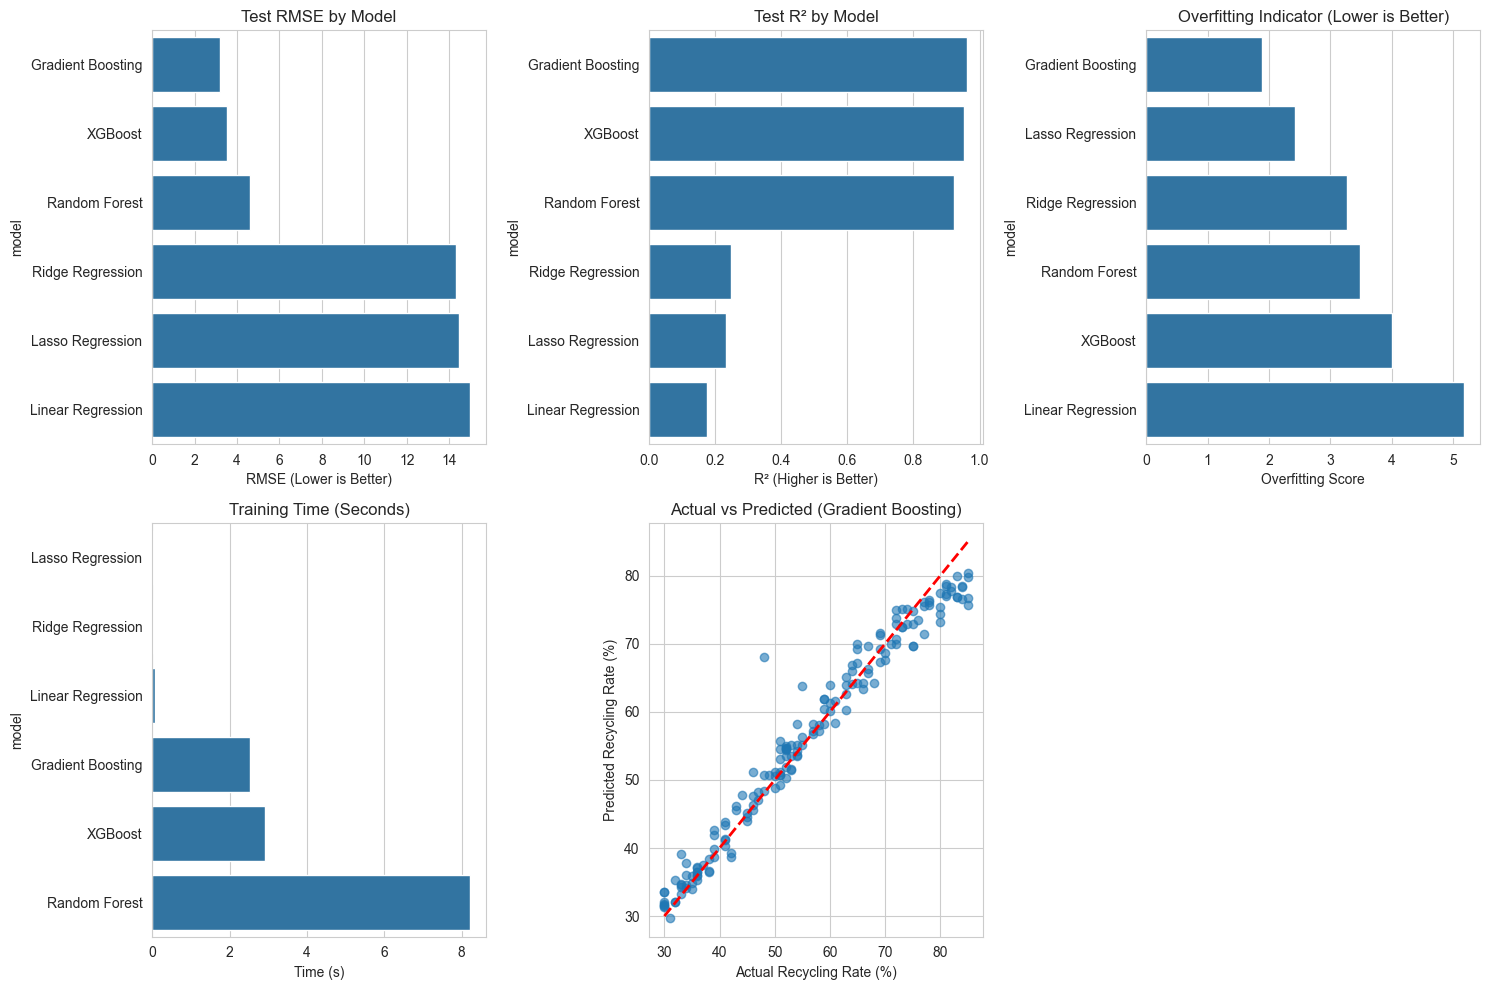

Best baseline model: Gradient Boosting


In [11]:
# Visualize Baseline Results
plt.figure(figsize=(15, 10))

# Plot 1: RMSE Comparison
plt.subplot(2, 3, 1)
sns.barplot(x='test_rmse', y='model', data=baseline_df.sort_values('test_rmse'))
plt.title('Test RMSE by Model')
plt.xlabel('RMSE (Lower is Better)')

# Plot 2: R² Comparison
plt.subplot(2, 3, 2)
sns.barplot(x='test_r2', y='model', data=baseline_df.sort_values('test_r2', ascending=False))
plt.title('Test R² by Model')
plt.xlabel('R² (Higher is Better)')

# Plot 3: Overfitting Analysis
plt.subplot(2, 3, 3)
baseline_df['overfit_indicator'] = baseline_df['overfit_rmse'] + baseline_df['overfit_r2'] * 10
sns.barplot(x='overfit_indicator', y='model', data=baseline_df.sort_values('overfit_indicator'))
plt.title('Overfitting Indicator (Lower is Better)')
plt.xlabel('Overfitting Score')

# Plot 4: Training Time
plt.subplot(2, 3, 4)
sns.barplot(x='training_time', y='model', data=baseline_df.sort_values('training_time'))
plt.title('Training Time (Seconds)')
plt.xlabel('Time (s)')

# Plot 5: Actual vs Predicted for best model
best_baseline_model_name = baseline_df.loc[baseline_df['test_rmse'].idxmin(), 'model']
best_baseline_model = models[best_baseline_model_name]
_, y_pred_best = evaluate_model(best_baseline_model, X_train, X_test, y_train, y_test)

plt.subplot(2, 3, 5)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Recycling Rate (%)')
plt.ylabel('Predicted Recycling Rate (%)')
plt.title(f'Actual vs Predicted ({best_baseline_model_name})')

plt.tight_layout()
plt.show()

print(f"Best baseline model: {best_baseline_model_name}")



In [12]:
# Hyperparameter tuning for top models


# Select top 2-3 models for tuning
top_models = baseline_df.nsmallest(3, 'test_rmse')['model'].values
print(top_models)
tuning_results = []

for model_name in top_models:
    print(f"\n--- Tuning {model_name} ---")
    
    if model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
        base_model = XGBRegressor(random_state=42)
        
    elif model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        base_model = RandomForestRegressor(random_state=42)
        
    elif model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 6, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        base_model = GradientBoostingRegressor(random_state=42)
    
    # Use RandomizedSearchCV for faster tuning
    search = RandomizedSearchCV(
        base_model, param_grid, n_iter=20, cv=5, scoring='neg_root_mean_squared_error',
        n_jobs=-1, random_state=42, verbose=1
    )
    
    start_time = time.time()
    search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Get best model
    best_model = search.best_estimator_
    
    # Evaluate tuned model
    results, y_pred_tuned = evaluate_model(best_model, X_train, X_test, y_train, y_test, f"{model_name} (Tuned)")
    results['training_time'] = tuning_time
    results['best_params'] = search.best_params_
    
    tuning_results.append(results)
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Tuned {model_name} - Test RMSE: {results['test_rmse']:.4f}")

['Gradient Boosting' 'XGBoost' 'Random Forest']

--- Tuning Gradient Boosting ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}
Tuned Gradient Boosting - Test RMSE: 2.7111

--- Tuning XGBoost ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Tuned XGBoost - Test RMSE: 2.8150

--- Tuning Random Forest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Tuned Random Forest - Test RMSE: 4.6802


In [13]:
# Cross-Validation for Final Model Selection
# Combine baseline and tuned results
final_results_df = pd.concat([baseline_df, pd.DataFrame(tuning_results)], ignore_index=True)# Perform cross-validation on top models
top_model_names = final_results_df.nsmallest(3, 'test_rmse')['model'].values

cv_results = []
for model_name in top_model_names:
    if '(Tuned)' in model_name:
        # Get the tuned model
        model_result = final_results_df[final_results_df['model'] == model_name].iloc[0]
        if 'XGBoost' in model_name:
            model = XGBRegressor(**model_result['best_params'], random_state=42)
        elif 'Random Forest' in model_name:
            model = RandomForestRegressor(**model_result['best_params'], random_state=42)
        elif 'Gradient Boosting' in model_name:
            model = GradientBoostingRegressor(**model_result['best_params'], random_state=42)
    else:
        model = models[model_name]
    
    # 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                               scoring='neg_root_mean_squared_error')
    cv_rmse_scores = -cv_scores
    
    cv_results.append({
        'model': model_name,
        'cv_mean_rmse': cv_rmse_scores.mean(),
        'cv_std_rmse': cv_rmse_scores.std(),
        'cv_min_rmse': cv_rmse_scores.min(),
        'cv_max_rmse': cv_rmse_scores.max()
    })

cv_df = pd.DataFrame(cv_results)
final_results_df = final_results_df.merge(cv_df, on='model', how='left')

print("Cross-Validation Results:")
display(cv_df.sort_values('cv_mean_rmse'))


Cross-Validation Results:


,model,cv_mean_rmse,cv_std_rmse,cv_min_rmse,cv_max_rmse
0,Gradient Boosting (Tuned),2.938934,0.104338,2.781816,3.082885
1,XGBoost (Tuned),3.222826,0.342619,2.692060,3.603229
2,Gradient Boosting,3.358384,0.153453,3.113129,3.513191


In [14]:
# Select and Save Final Model
print("\n=== FINAL MODEL SELECTION ===")

# Select model with best test RMSE and good cross-validation performance
final_model_name = final_results_df.nsmallest(1, 'test_rmse')['model'].values[0]
final_model_info = final_results_df[final_results_df['model'] == final_model_name].iloc[0]

print(f"Selected Final Model: {final_model_name}")

# Train the final model on entire training data
if '(Tuned)' in final_model_name:
    if 'XGBoost' in final_model_name:
        final_model = XGBRegressor(**final_model_info['best_params'], random_state=42)
    elif 'Random Forest' in final_model_name:
        final_model = RandomForestRegressor(**final_model_info['best_params'], random_state=42)
    elif 'Gradient Boosting' in final_model_name:
        final_model = GradientBoostingRegressor(**final_model_info['best_params'], random_state=42)
else:
    final_model = models[final_model_name]

# Train on full training data
final_model.fit(X_train, y_train)

# Final evaluation
final_results, y_test_pred_final = evaluate_model(final_model, X_train, X_test, y_train, y_test, "Final Model")

print(f"Final Model Performance:")
print(f"  Test RMSE: {final_results['test_rmse']:.4f}")
print(f"  Test R²: {final_results['test_r2']:.4f}")
print(f"  Test MAE: {final_results['test_mae']:.4f}")



=== FINAL MODEL SELECTION ===
Selected Final Model: Gradient Boosting (Tuned)
Final Model Performance:
  Test RMSE: 2.7111
  Test R²: 0.9730
  Test MAE: 1.9709



=== FEATURE IMPORTANCE ANALYSIS ===


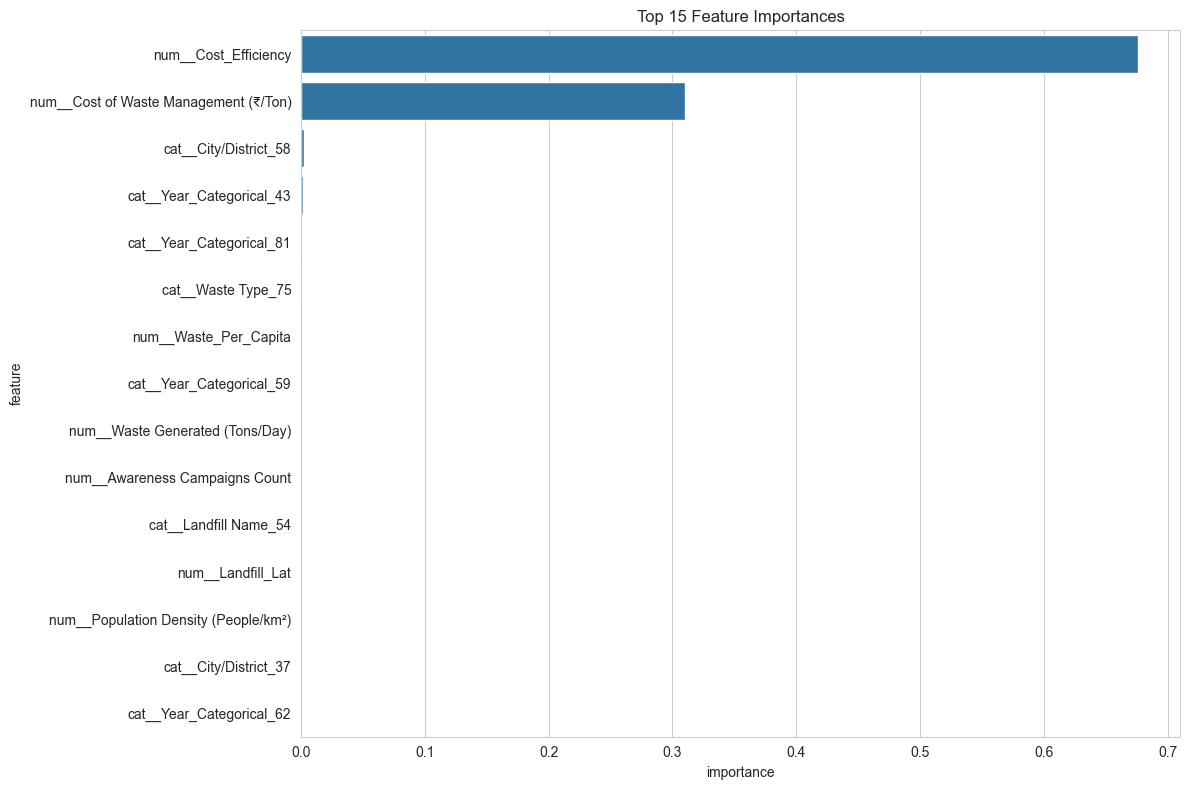

Top 10 Most Important Features:


,feature,importance
10,num__Cost_Efficiency,0.676117
3,num__Cost of Waste Management (₹/Ton),0.310105
39,cat__City/District_58,0.002105
192,cat__Year_Categorical_43,0.001743
230,cat__Year_Categorical_81,0.000642
112,cat__Waste Type_75,0.000635
9,num__Waste_Per_Capita,0.000361
208,cat__Year_Categorical_59,0.000357
0,num__Waste Generated (Tons/Day),0.000282
4,num__Awareness Campaigns Count,0.000237


In [15]:
# Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

if hasattr(final_model, 'feature_importances_'):
    # Get feature names (this might need adjustment based on your preprocessing)
    try:
        feature_names = X.columns.tolist()
    except:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    importances = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    display(feature_importance_df.head(10))



=== RESIDUAL ANALYSIS ===


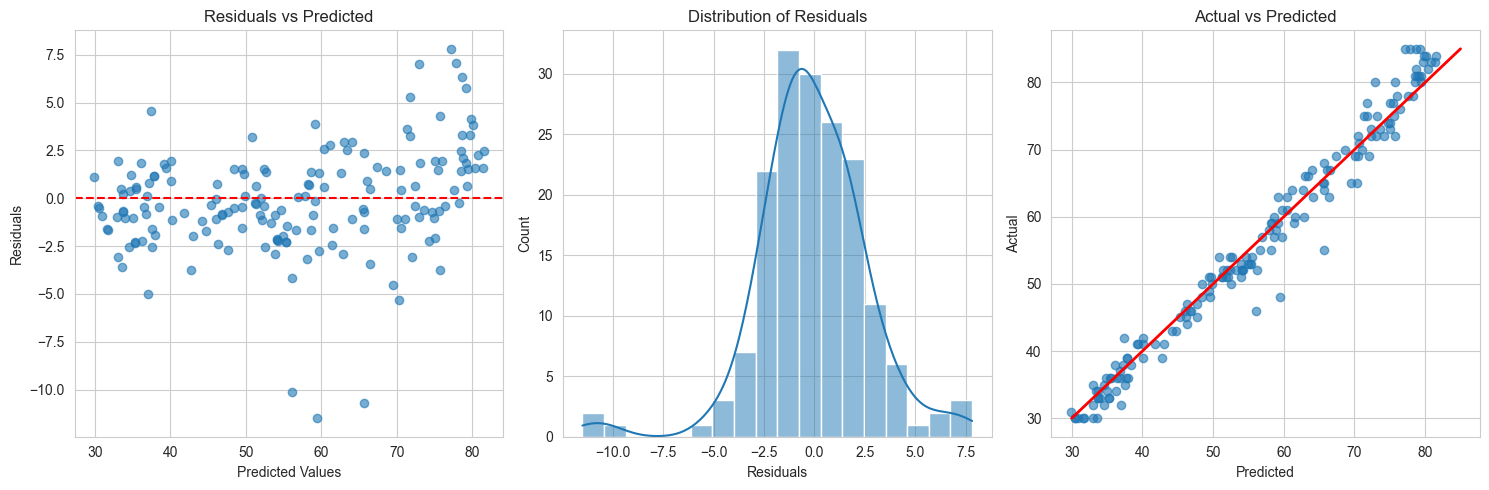

Residual Statistics:
  Mean: -0.1074
  Std: 2.7170
  Skewness: -0.5559


In [16]:
# Cell 11: Residual Analysis
print("\n=== RESIDUAL ANALYSIS ===")

residuals = y_test - y_test_pred_final

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_pred_final, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')

plt.subplot(1, 3, 3)
plt.scatter(y_test_pred_final, y_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs Predicted')

plt.tight_layout()
plt.show()

# Check residual statistics
print(f"Residual Statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std: {residuals.std():.4f}")
print(f"  Skewness: {pd.Series(residuals).skew():.4f}")


In [17]:
# Cell 12: Save Final Model and Results
print("\n=== SAVING MODEL AND RESULTS ===")

# Save the final model
joblib.dump(final_model, '../models/final_model.pkl')
print("✓ Final model saved to '../models/final_model.pkl'")

# Save predictions for submission
submission_df = pd.DataFrame({
    'Actual_Recycling_Rate': y_test,
    'Predicted_Recycling_Rate': y_test_pred_final
})

# Add original identifiers if available
try:
    submission_df['City'] = raw_df.loc[test_mask, 'City/District'].values
    submission_df['Waste_Type'] = raw_df.loc[test_mask, 'Waste Type'].values
    submission_df['Year'] = raw_df.loc[test_mask, 'Year'].values
except:
    pass

submission_df.to_csv('../predictions.csv', index=False)
print("✓ Predictions saved to '../predictions.csv'")

# Save model performance report
performance_report = final_results_df.to_dict('records')
import json
with open('../models/model_performance.json', 'w') as f:
    json.dump(performance_report, f, indent=2)
print("✓ Model performance report saved")



=== SAVING MODEL AND RESULTS ===
✓ Final model saved to '../models/final_model.pkl'
✓ Predictions saved to '../predictions.csv'
✓ Model performance report saved


In [18]:
# Cell 13: Model Deployment Preparation
print("\n=== DEPLOYMENT PREPARATION ===")

# Create a simple function for inference
def predict_recycling_rate(model, preprocessor, input_data):
    """
    Predict recycling rate for new data
    """
    # Preprocess the input data
    X_processed = preprocessor.transform(input_data)
    
    # Make prediction
    prediction = model.predict(X_processed)
    
    return prediction[0]

# Test the function with sample data
try:
    preprocessor = joblib.load('../models/preprocessor.pkl')
    sample_prediction = predict_recycling_rate(final_model, preprocessor, X_test[:1])
    print(f"✓ Inference function tested. Sample prediction: {sample_prediction:.2f}%")
except Exception as e:
    print(f"✗ Inference test failed: {e}")



=== DEPLOYMENT PREPARATION ===
✗ Inference test failed: columns are missing: {'Waste Type', 'Landfill Capacity (Tons)', 'Population Density (People/km²)', 'Cost of Waste Management (₹/Ton)', 'Landfill_Lon', 'Awareness Campaigns Count', 'Landfill Name', 'Municipal Efficiency Score (1-10)', 'City/District', 'Waste_Per_Capita', 'Year_Categorical', 'Year', 'Waste Generated (Tons/Day)', 'Cost_Efficiency', 'Landfill_Lat'}


In [19]:
# Cell 14: Summary
print("\n=== TRAINING SUMMARY ===")
print(f"✅ Best Model: {final_model_name}")
print(f"✅ Test RMSE: {final_results['test_rmse']:.4f}")
print(f"✅ Test R²: {final_results['test_r2']:.4f}")
print(f"✅ Models Compared: {len(final_results_df)}")
print(f"✅ Cross-Validation Mean RMSE: {final_results_df[final_results_df['model']==final_model_name]['cv_mean_rmse'].values[0]:.4f}")



=== TRAINING SUMMARY ===
✅ Best Model: Gradient Boosting (Tuned)
✅ Test RMSE: 2.7111
✅ Test R²: 0.9730
✅ Models Compared: 9
✅ Cross-Validation Mean RMSE: 2.9389
